<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [ ]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

In [ ]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np


## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [ ]:
# скачаем данные
!wget https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/HH%20Spot%20Price.csv
!wget https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv

--2021-06-03 13:00:40--  https://raw.githubusercontent.com/rishabh89007/Time_Series_Datasets/main/HH%20Spot%20Price.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4420 (4.3K) [text/plain]
Saving to: ‘HH Spot Price.csv’

HH Spot Price.csv   100%[===================>]   4.32K  --.-KB/s    in 0s      

2021-06-03 13:00:40 (45.2 MB/s) - ‘HH Spot Price.csv’ saved [4420/4420]

--2021-06-03 13:00:40--  https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [ ]:
# считаем файлы
from sklearn.preprocessing import MinMaxScaler

ts1 = pd.read_csv('HH Spot Price.csv')  #monthly
ts1['Unnamed: 0'] = pd.to_datetime(ts1['Unnamed: 0'])
ts1 = ts1.rename(columns={'Unnamed: 0': 'date', 'Henry Hub Natural Gas Spot Price, Monthly (Dollars per Million Btu)': 'y'})
y1 = ts1[ts1.columns[1]].values

ts2 = pd.read_csv('owid-covid-data.csv')  #daily
ts2_date = sorted(ts2['date'].unique())

scaler = MinMaxScaler()
y2 = ts2.groupby(by='date').sum()['new_cases'].values.reshape(-1, 1)
y2 = scaler.fit_transform(y2)
y2 = np.ravel(y2)

ts2 = pd.DataFrame(data={'date': ts2_date, 'y': y2})
ts2['date'] = pd.to_datetime(ts2['date'])

print('ts1:', ts1.shape[0], 'наблюдений')
print('ts2:', ts2.shape[0], 'наблюдений')

ts1: 291 наблюдений
ts2: 519 наблюдений


In [ ]:
print(ts1.dtypes)
ts1.head()

date    datetime64[ns]
y              float64
dtype: object


,date,y
0,1997-01-01,3.45
1,1997-02-01,2.15
2,1997-03-01,1.89
3,1997-04-01,2.03
4,1997-05-01,2.25


In [ ]:
print(ts2.dtypes)
ts2.head()

date    datetime64[ns]
y              float64
dtype: object


,date,y
0,2020-01-01,0.0
1,2020-01-02,0.0
2,2020-01-03,0.0
3,2020-01-04,0.0
4,2020-01-05,0.0


In [ ]:
# сделаем разбиение на train/test
from sklearn.model_selection import train_test_split

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(ts1['date'].values, ts1['y'].values, shuffle=False, test_size=0.15)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(ts2['date'].values, ts2['y'].values, shuffle=False, test_size=0.1)

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

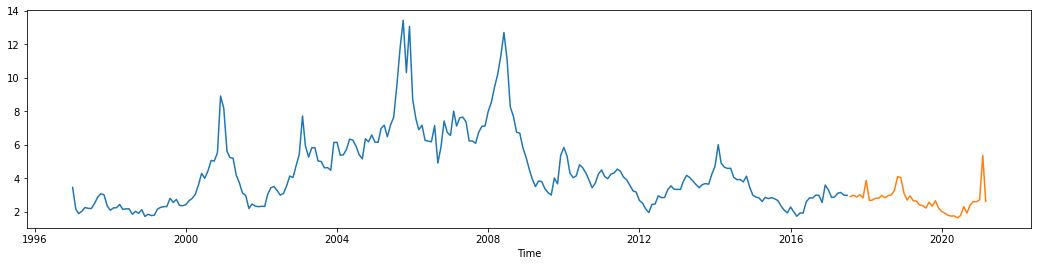

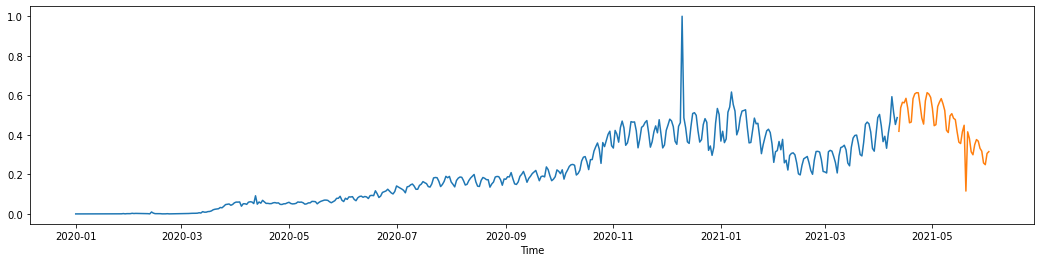

In [ ]:
# отрисуем временные ряды
plt.figure(figsize=(18, 4))
plt.plot(x_train_1, y_train_1, x_test_1, y_test_1)
plt.xlabel('Time')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(x_train_2, y_train_2, x_test_2, y_test_2)
plt.xlabel('Time')
plt.show()

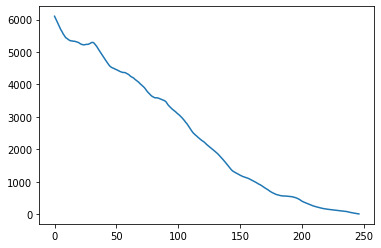

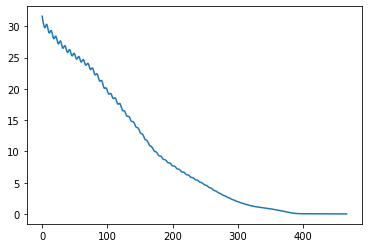

In [ ]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')
cor1 = np.correlate(y_train_1, y_train_1, mode='full')
cor1 = cor1[cor1.size // 2:]
plt.plot(cor1)
plt.show()

cor2 = np.correlate(y_train_2, y_train_2, mode='full')
cor2 = cor2[cor2.size // 2:]
plt.plot(cor2)
plt.show()

In [ ]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

# ваш код обучения моделей здесь
y_train_1 = pd.Series(data=y_train_1)
forecaster1 = NaiveForecaster()
forecaster1.fit(y_train_1)

forecaster2 = NaiveForecaster(sp=12)
forecaster2.fit(y_train_1)

NaiveForecaster(sp=12)

In [ ]:
def metrics(model1, model2, name1, name2, y_test=y_test_1, x_test=x_test_1, y_train=y_train_1, x_train=x_train_1, mode=False):
    y_pred_1 = model1.predict(fh)
    print(name1, 'MAE:', round(mean_absolute_error(y_test, y_pred_1), 2))

    y_pred_2 = model2.predict(fh)
    print(name2, 'MAE:', round(mean_absolute_error(y_test, y_pred_2), 2))

    plt.figure(figsize=(18, 4))
    plt.plot(x_train, y_train, label='Train')
    plt.plot(x_test, y_test, label='True test')
    plt.plot(x_test, y_pred_1, label=name1)
    plt.plot(x_test, y_pred_2, label=name2)
    plt.xlabel('Time')
    plt.legend()
    plt.show()

Last MAE: 0.56
Last -12 MAE: 0.6


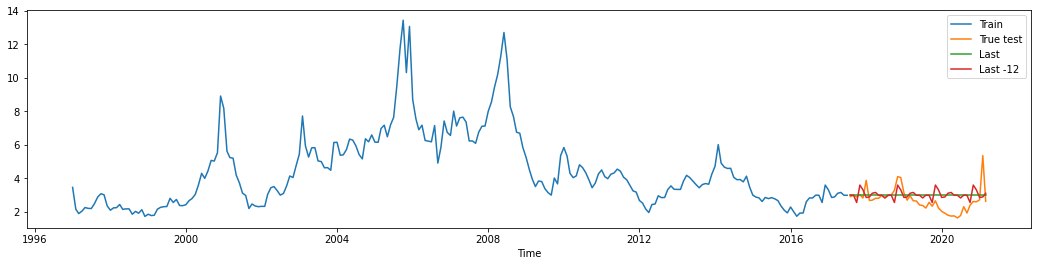

In [ ]:
# посчитайте метрики на test
from sklearn.metrics import mean_absolute_error

fh_test_1 = np.arange(len(x_train_1) + 1, len(x_test_1) + len(x_train_1) + 1)
fh = ForecastingHorizon(fh_test_1, is_relative=False)
metrics(forecaster1, forecaster2, 'Last', 'Last -12')

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

In [ ]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster3 = ARIMA(order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True)
forecaster3.fit(y_train_1)

forecaster4 = AutoARIMA(sp=12, suppress_warnings=True)
forecaster4.fit(y_train_1)

AutoARIMA(sp=12, suppress_warnings=True)

ARIMA MAE: 0.53
AutoARIMA MAE: 0.56


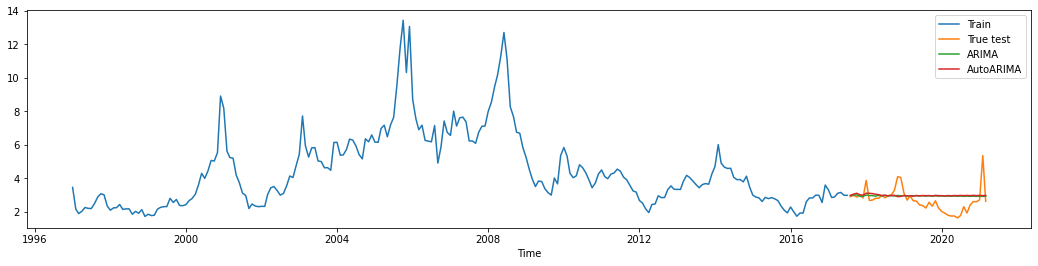

In [ ]:
# посчитайте метрики на test
metrics(forecaster3, forecaster4, 'ARIMA', 'AutoARIMA')

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь
train_df_1 = pd.DataFrame(data={'date_col': x_train_1, 'response_col': y_train_1})
test_df_1 = pd.DataFrame(data={'date_col': x_test_1, 'response_col': y_test_1})
response_col = 'response_col'
date_col = 'date_col'

lgt = LGTFull(seasonality=36, response_col=response_col, date_col=date_col, 
              num_warmup=3000, regression_penalty='auto_ridge', auto_ridge_scale=0.9, slope_sm_input=0.85)
lgt.fit(df=train_df_1)

dlt = DLTFull(seasonality=36, response_col=response_col, date_col=date_col, 
              num_warmup=3000, regression_penalty='auto_ridge', auto_ridge_scale=0.9, slope_sm_input=0.85)
dlt.fit(df=train_df_1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


LGTFull MAE: 0.48
DLTFull MAE: 0.37


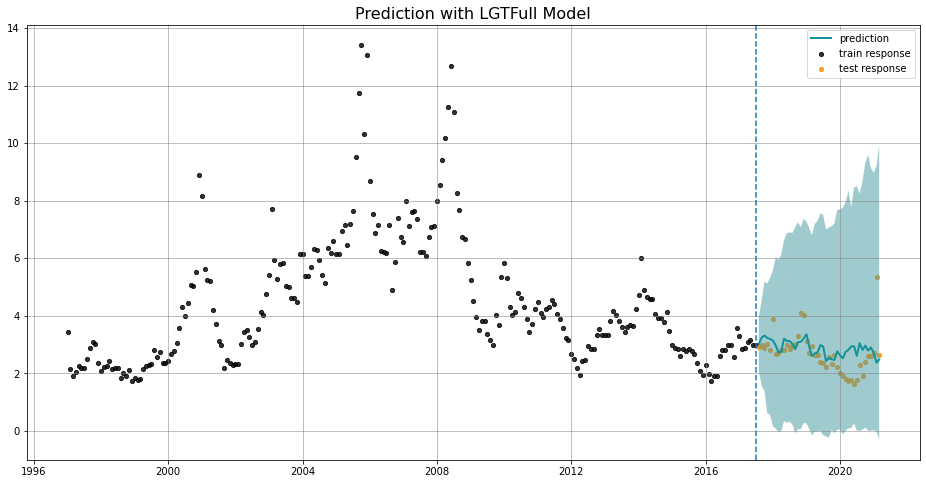

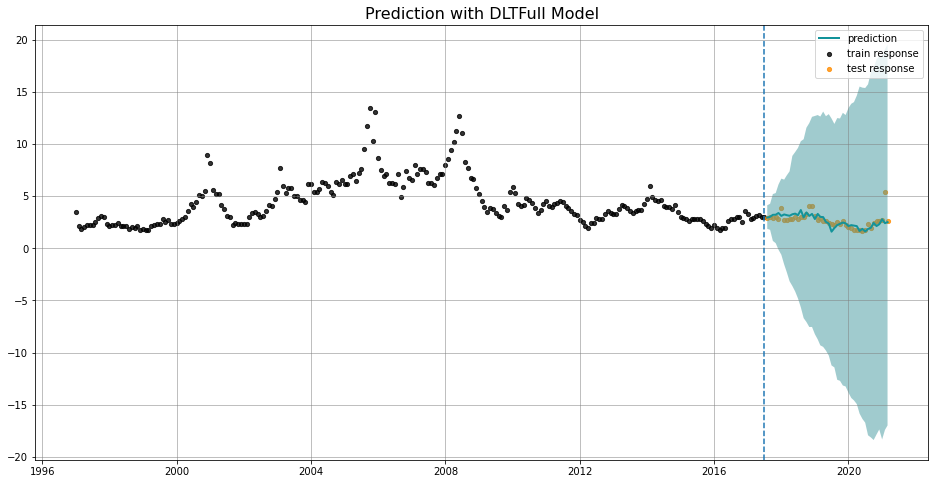

In [ ]:
# посчитайте метрики на test
from orbit.diagnostics.plot import plot_predicted_data

predicted_df_1 = lgt.predict(df=test_df_1)
print('LGTFull MAE:', round(mean_absolute_error(test_df_1['response_col'], predicted_df_1['prediction']), 2))
predicted_df_2 = dlt.predict(df=test_df_1)
print('DLTFull MAE:', round(mean_absolute_error(test_df_1['response_col'], predicted_df_2['prediction']), 2))

_ = plot_predicted_data(training_actual_df=train_df_1, predicted_df=predicted_df_1,
                        date_col=date_col, actual_col=response_col,
                        test_actual_df=test_df_1, title='Prediction with LGTFull Model')

_ = plot_predicted_data(training_actual_df=train_df_1, predicted_df=predicted_df_2,
                        date_col=date_col, actual_col=response_col,
                        test_actual_df=test_df_1, title='Prediction with DLTFull Model')

### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь
forecaster5 = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster5.fit(y_train_1)

forecaster6 = AutoETS(trend='add', seasonal='multiplicative', sp=12)
forecaster6.fit(y_train_1)

AutoETS(seasonal='multiplicative', sp=12, trend='add')

ETS MAE: 0.52
AutoETS MAE: 0.52


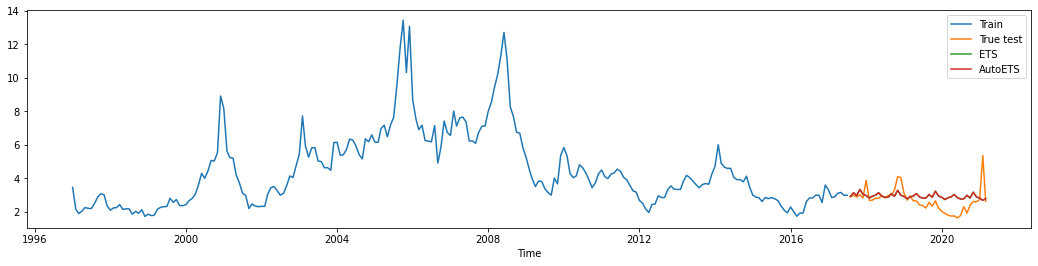

In [ ]:
# посчитайте метрики на test
metrics(forecaster5, forecaster6, 'ETS', 'AutoETS')

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь
y_train_2 = pd.Series(data=y_train_2)
forecaster7 = NaiveForecaster()
forecaster7.fit(y_train_2)

forecaster8 = NaiveForecaster(sp=7)
forecaster8.fit(y_train_2)

NaiveForecaster(sp=7)

Last MAE: 0.1
Last - 7 MAE: 0.09


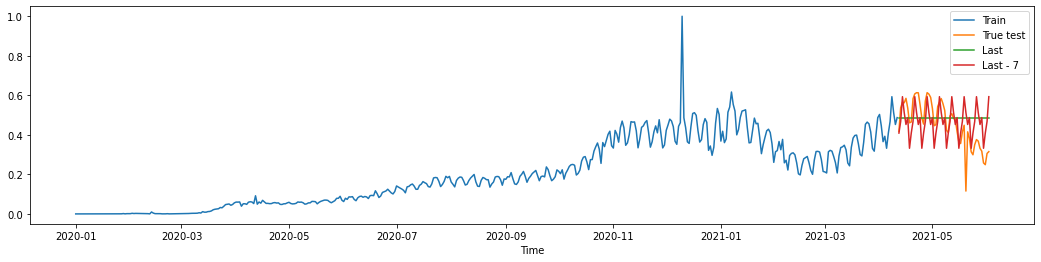

In [ ]:
# посчитайте метрики на test
fh_test_2 = np.arange(len(x_train_2) + 1, len(x_test_2) + len(x_train_2) + 1)
fh = ForecastingHorizon(fh_test_2, is_relative=False)
metrics(forecaster7, forecaster8, 'Last', 'Last - 7', y_test=y_test_2, x_test=x_test_2, y_train=y_train_2, x_train=x_train_2, mode=True)

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь
train_df_2 = pd.DataFrame(data={'date_col': x_train_2, 'response_col': y_train_2})
test_df_2 = pd.DataFrame(data={'date_col': x_test_2, 'response_col': y_test_2})
response_col = 'response_col'
date_col = 'date_col'

ktr = KTRLiteMAP(response_col=response_col, date_col=date_col, seasonality=14, 
                 seasonality_fs_order=2, level_knot_scale=0.2, span_level=0.3, 
                 span_coefficients=0.2)
ktr.fit(df=train_df_2)

KTRLiteMAP MAE: 0.105


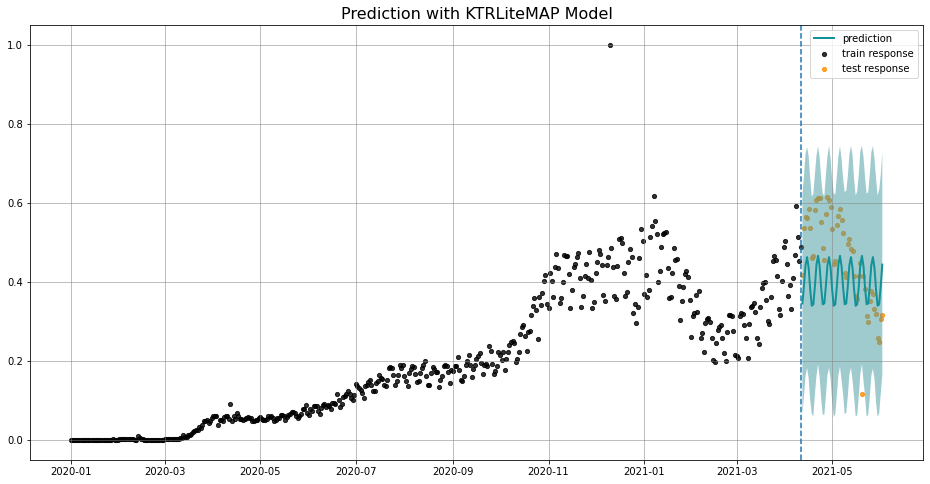

In [ ]:
predicted_df_3 = ktr.predict(df=test_df_2)
print('KTRLiteMAP MAE:', round(mean_absolute_error(test_df_2['response_col'], predicted_df_3['prediction']), 3))

_ = plot_predicted_data(training_actual_df=train_df_2, predicted_df=predicted_df_3,
                        date_col=date_col, actual_col=response_col,
                        test_actual_df=test_df_2, title='Prediction with KTRLiteMAP Model')

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь
train_df_2 = pd.DataFrame(data={'ds': x_train_2, 'y': y_train_2})
test_df_2 = pd.DataFrame(data={'ds': x_test_2, 'y': y_test_2})

pr = Prophet()
pr.fit(train_df_2)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet MAE: 0.152


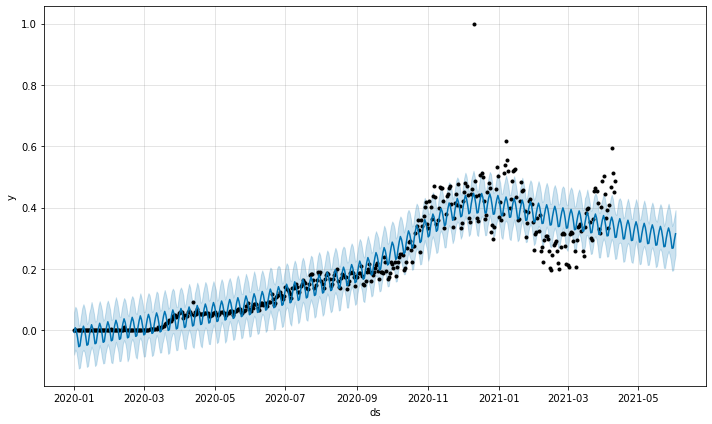

In [ ]:
# посчитайте метрики на test
future = pr.make_future_dataframe(periods=len(x_test_2))
predicted_df_4 = pr.predict(future)
y_pred_4 = predicted_df_4['yhat'].values[-len(test_df_2):]

print('Prophet MAE:', round(mean_absolute_error(test_df_2['y'], y_pred_4), 3))
fig1 = pr.plot(predicted_df_4)

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте пресказания